# Estimating Activity Through Point of Interest Visits Using Mobility Data

Analyzing the frequency of visits within or near points of interest has the potential to provide insights into the economic ramifications of conflicts and disasters. In a manner akin to the now discontinued [Google Community Mobility Reports](https://www.google.com/covid19/mobility/), the following methodology aims to monitor fluctuations in mobility, quantified by visit counts, within a set of [OpenStreetMap](https://www.openstreetmap.org/#map=5/38.007/-95.844) points of interest relative to a baseline.

In [3]:
import datetime

import colorcet as cc
import dask.dataframe as dd
import dask_geopandas
import datashader
import geopandas
import holoviews as hv
from bokeh.models import HoverTool, Legend, Span, TabPanel, Tabs, Title
from bokeh.plotting import figure, show
from holoviews.element.tiles import CartoDark
from holoviews.operation.datashader import rasterize

In [ ]:
# supress error (numpy==1.24.3)
import warnings

import numpy as np

np.warnings = warnings

## Data

In this section, we import from the data sources, available either publicly or through data sharing agreements. Please note that `data` is a placeholder location where the data must be placed. When using non-public data, please carefully abide by your organization's data privacy policy, data classification and the terms and conditions.

In [5]:
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html
TAG = "tourism"

### Area of Interest

In this study, the **area of interest** is *Egypt's Red Sea Riviera* emcompassing the *Red Sea* and *South Sinai* governorates as shown below.

In [5]:
EGY = geopandas.read_file(
    "../../data/egy_admbnda_adm2_capmas_20170421/egy_admbnda_adm2_capmas_20170421.shp"
)

AOI = EGY[
    EGY["ADM1_PCODE"].isin(
        [
            "EG31",
            "EG35",
        ]
    )
]
AOI.explore(color="blue")

### Points of Interest 

Using the [Humanitarian OpenStreetMap](https://hotosm.org) via [HDX](https://data.humdata.org/) , the project team acquired [OpenStreetMap points of interest](https://data.humdata.org/dataset/hotosm_egy_points_of_interest) within a defined boundary encompassing the  [area of interest](#area-of-interest) as specified. 

In [6]:
POI = (
    geopandas.read_file(
        "https://s3.us-east-1.amazonaws.com/production-raw-data-api/ISO3/EGY/points_of_interest/points/hotosm_egy_points_of_interest_points_shp.zip"
    )
    .set_crs("EPSG:4326")
    .sjoin(AOI, predicate="within")
)

We selected [OpenStreetMap points of interest](https://data.humdata.org/dataset/hotosm_egy_points_of_interest) tagged as `tourism` and create a **100m** buffer centered at the coordinates informed. 

In [ ]:
POI = POI[
    [
        "osm_id",
        "name",
        TAG,
        "ADM0_PCODE",
        "ADM1_PCODE",
        "ADM2_PCODE",
        "ADM1_EN",
        "ADM2_EN",
        "geometry",
    ]
]

# filter tag
POI = POI[~POI[TAG].isnull()]

# create buffer
POI["geometry"] = POI["geometry"].to_crs("EPSG:3857").buffer(100).to_crs("EPSG:4326")

To illustrate, we visualize below the points of interest.

In [8]:
POI.explore(color="red")

Based on [OpenStreetMap points of interest](https://data.humdata.org/dataset/hotosm_egy_points_of_interest), we visualize the breakdown below, 

In [9]:
POI[TAG].value_counts()

tourism
hotel             245
viewpoint         102
attraction         91
information        28
apartment          20
hostel             17
camp_site          15
guest_house        15
artwork            12
chalet             12
picnic_site         7
museum              7
wilderness_hut      4
alpine_hut          2
yes                 2
motel               2
theme_park          1
ruins               1
caravan_site        1
gallery             1
Name: count, dtype: int64

In [10]:
POI[TAG] = (
    POI[TAG]
    .map(
        dict(
            hotel="hotel",
            hostel="hotel",
            motel="hotel",
            information="information",
            viewpoint="viewpoint",
            attraction="attraction",
            museum="attraction",
        ),
        na_action=None,
    )
    .fillna("other")
)

### Mobility Data

The project team acquired longitudinal human mobility data. [Veraset Movement](https://www.veraset.com/products/movement/) provides a panel of human mobility data, based on data collection of GPS-enabled devices location. The data consisted of anonymized timestamped geographical points generated by GPS-enabled devices, located in Egypt and spanning the period shown below.

In [11]:
ddf = dd.read_parquet(
    ["s3://wbgggscecovid19dev-mobility/country=EG/year=*/date=*/*.parquet"],
)

In [ ]:
ddf = ddf.persist()

# calculating `date` from the date and time the points were collected.
# ddf["date"] = dd.to_datetime(ddf["datetime"].dt.date)
ddf["date"] = dd.to_datetime(ddf["date"])

First, we calculate the cardinality, 

In [12]:
len(ddf)

1131632964

Now, we calculate the temporal extent, 

In [13]:
print(
    "From",
    ddf["datetime"].min().compute().strftime("%b %d, %Y"),
    "to",
    ddf["datetime"].max().compute().strftime("%b %d, %Y"),
)

From Oct 01, 2022 to Mar 15, 2024


And visualize the mobility data panel's spatial density.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
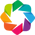

/opt/conda/lib/python3.10/site-packages/holoviews/core/util.py:1572: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/opt/conda/lib/python3.10/site-packages/holoviews/core/util.py:1572: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.5, use 'transform_reference' instead.
  value = param_value_if_widget(value)


:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .Image.I :Image   [x,y]   (x_y Count)

In [15]:
hv.extension("bokeh")

# sampling
data = dd.read_parquet(
    ["s3://wbgggscecovid19dev-mobility/country=EG/year=2024/*/*.parquet"],
    columns=["longitude", "latitude"],
)
data["longitude"] = data["longitude"].astype("float")
data["latitude"] = data["latitude"].astype("float")

x, y = datashader.utils.lnglat_to_meters(data["longitude"], data["latitude"])
points = hv.Points(data.assign(x=x, y=y), ["x", "y"])
points = rasterize(points).opts(
    tools=["hover"],
    colorbar=True,
    colorbar_position="bottom",
    cmap=cc.fire,
    cnorm="eq_hist",
)
tiles = CartoDark().opts(
    title="Egypt: Mobility Data Spatial Distribution",
    alpha=0.75,
    width=780,
    height=600,
    bgcolor="black",
)
tiles * points

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Visualization of the mobility data panel's spatial distribution. In 2024, the panel emcompasses approximately 20 million points. Source: Veraset Movement. 
```

## Methodology

In parallel with the now discontinued [Google Community Mobility Reports](https://www.google.com/covid19/mobility/), the outlined methodology aims to monitor variations in mobility, measured by the frequency of visits, within points of interest sourced from OpenStreetMap compared to a baseline. It's important to note that the mobility data reflects a subset of the overall population within an area, specifically individuals who have activated the Location Services setting on their mobile devices. It is crucial to understand that this data does not represent total population density. Additionally, we highlight that this calculation is based on a spatial join approach, which determines whether a device has been detected within an area of interest at least once. This method, while straightforward, represents a simplified approach compared to more advanced techniques such as estimating stay locations and visits.



Utilizing [Dask-GeoPandas](https://dask-geopandas.readthedocs.io/en/stable/), we conduct a spatial join between the device traces and points of interest. Subsequently, we perform spatiotemporal aggregation of device counts by H3 grid cells and daily intervals, as well as by landuse classifications such as residential areas.

In [16]:
gddf = dask_geopandas.from_dask_dataframe(
    ddf[["uid", "hex_id", "date"]],
    geometry=dask_geopandas.points_from_xy(ddf, "longitude", "latitude"),
).set_crs("EPSG:4326")

Next, we see the spatial join being executed to calculate the device density for each spatial and for each temporal bin. Finally, the results joined into administrative divisions. 

In [17]:
result = (
    gddf.sjoin(POI, predicate="within")
    .groupby([TAG, "ADM2_PCODE", "date"], observed=True)["uid"]
    .nunique()
    .to_frame(name="count")
    .reset_index()
    .compute()
)

## Results

In this section, we visualize count of devices detected within each of the following [OpenStreetMap](https://www.openstreetmap.org/) tags.

In [18]:
COLORS = [
    "#4E79A7",  # Blue
    "#F28E2B",  # Orange
    "#E15759",  # Red
    "#76B7B2",  # Teal
    "#59A14F",  # Green
    "#EDC948",  # Yellow
    "#B07AA1",  # Purple
    "#FF9DA7",  # Pink
    "#9C755F",  # Brown
    "#BAB0AC",  # Gray
    "#7C7C7C",  # Dark gray
    "#6B4C9A",  # Violet
    "#D55E00",  # Orange-red
    "#CC61B0",  # Magenta
    "#0072B2",  # Bright blue
    "#329262",  # Peacock green
    "#9E5B5A",  # Brick red
    "#636363",  # Medium gray
    "#CD9C00",  # Gold
    "#5D69B1",  # Medium blue
]

In [19]:
FEATURES = POI[TAG].value_counts().index
FEATURES

Index(['hotel', 'viewpoint', 'attraction', 'other', 'information'], dtype='object', name='tourism')

Through the aggregation of visit counts, we present a smoothed tally indicating the number of detected users within the entire area for each 1-day period.

In [30]:
data = result.pivot_table(
    values=["count"], index=["date"], columns=[TAG], aggfunc="sum"
)

In [31]:
def plot_visits(data, title="Points of Interest Visit Trends"):
    """Plot number of visits to OSM points of interest"""

    p = figure(
        title=title,
        width=750,
        height=750,
        x_axis_label="Date",
        x_axis_type="datetime",
        y_axis_label="Count of Devices",
        y_axis_type="log",
        y_range=(0.75, 5 * 10**3),
        tools="pan,reset,save,box_select",
    )
    p.add_layout(Legend(), "right")
    p.add_layout(
        Title(
            text=f"Count of Devices Identified with OpenStreetMap '{TAG}' tag",
            text_font_size="12pt",
            text_font_style="italic",
        ),
        "above",
    )
    p.add_layout(
        Title(
            text=f"Source: Veraset Movement. Creation date: {datetime.datetime.today().strftime('%d %B %Y')}. Feedback: datalab@worldbank.org.",
            text_font_size="10pt",
            text_font_style="italic",
        ),
        "below",
    )

    # plot spans
    p.renderers.extend(
        [
            Span(
                location=datetime.datetime(2023, 10, 7),
                dimension="height",
                line_color="grey",
                line_width=2,
                line_dash=(4, 4),
            ),
            Span(
                location=datetime.datetime(2023, 11, 17),
                dimension="height",
                line_color="grey",
                line_width=2,
                line_dash=(4, 4),
            ),
        ]
    )

    # plot lines
    renderers = []
    for column, color in zip(FEATURES, COLORS):
        try:
            r = p.line(
                data.index,
                data[column],
                legend_label=column,
                line_color=color,
                line_width=2,
            )
            if column != "hotel":
                r.muted = True
        except KeyError:
            pass

    p.add_tools(
        HoverTool(
            tooltips=[("Date", "@x{%F}"), ("Count", "@y")],
            formatters={"@x": "datetime"},
        )
    )

    p.legend.location = "bottom_left"
    p.legend.click_policy = "mute"
    p.title.text_font_size = "16pt"
    # p.sizing_mode = "scale_both"
    return p

In [32]:
data.columns = [c[1] for c in data.columns]
show(plot_visits(data))

### By administrative divisions

Through the aggregation of visit counts, we present a smoothed tally indicating the number of detected devices within each first-level administrative division and for each 1-day time period. 

In [33]:
NAMES = dict(zip(AOI["ADM2_PCODE"], AOI["ADM2_EN"]))

In [34]:
tabs = []

# iterate over first-level administrative divisions
for pcode in sorted(result["ADM2_PCODE"].unique()):
    data = result[result["ADM2_PCODE"] == pcode].pivot_table(
        "count", index=["date"], columns=[TAG], aggfunc="sum", observed=True
    )
    tabs.append(
        TabPanel(
            child=plot_visits(
                data,
                title=f"Points of Interest Visit Trends in {NAMES.get(pcode)} ({pcode})",
            ),
            title=NAMES.get(pcode),
        )
    )

# plot panel
tabs = Tabs(tabs=tabs)
show(tabs)

## Limitations

### Limitations of using mobility data to estimate economic activity
```{warning}
- **Sample Bias:** The sampled population is composed of GPS-enabled devices drawn out from a longituginal mobility data panel. It is important to emphasize the sampled population is obtained via convenience sampling and that the mobility data panel represents only a subset of the total population in an area at a time, specifically only users that turned on location tracking on their mobile device. Thus, derived metrics do not represent the total population density. 
- **Incomplete Coverage:** Mobility data is typically collected from sources such as mobile phone networks, GPS devices, or transportation systems. These sources may not be representative of the entire population or all economic activities, leading to sample bias and potentially inaccurate estimations.Not all individuals or businesses have access to devices or services that generate mobility data. This can result in incomplete coverage and potential underrepresentation of certain demographic groups or economic sectors.
- **Lack of Contextual Information:** Mobility data primarily captures movement patterns and geolocation information. It may lack other crucial contextual information, such as transactional data, business types, or specific economic activities, which are essential for accurate estimation of economic activity.
```
### Limitations of using points of interest database from OpenStreetMap
```{warning}
- **Data Quality:** OpenStreetMap (OSM) relies on user contributions, which can vary in quality and may not always be up-to-date. The accuracy and completeness of the points of interest (POI) database in OSM can vary significantly across different regions and categories.
- **Bias and Incompleteness:** OSM data can be biased towards areas or categories that attract more active contributors. Certain regions or types of businesses may be underrepresented, leading to incomplete or skewed data, especially in less-populated or less-developed areas.
- **Lack of Standardization:** OSM does not enforce strict data standards, resulting in variations in the format, categorization, and attribute information of POIs. This lack of standardization can make it challenging to compare and analyze data consistently across different regions or time periods.
- **Verification and Validation:** While OSM relies on community-driven efforts for data verification, the absence of a centralized authority or rigorous validation process can introduce errors and inaccuracies. It may be difficult to ascertain the reliability of the information contained in the POI database.
- **Limited Contextual Information:** The OSM database primarily focuses on geospatial information, such as coordinates and basic attributes of POIs. It may lack additional contextual information, such as detailed business descriptions, operational hours, or transactional data, which can limit its usefulness for comprehensive economic analysis.
```